<a href="https://colab.research.google.com/github/Crawnicles/Algo-trading-project/blob/main/SPX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

In [ ]:
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

## Define a function to build a dataframe to get historical data using the ticker
def get_historical_data(symbol, start_date):
    api_key = '627b5accb1ab483e8715d46a6f460e85'
    api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&interval=1day&outputsize=5000&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['values']).iloc[::-1].set_index('datetime').astype(float)
    df = df[df.index >= start_date]
    df.index = pd.to_datetime(df.index)
    return df

spx = get_historical_data('SPX', '2020-01-01')
print(spx)

                  open        high         low       close        volume
datetime                                                                
2020-01-02  3244.66992  3258.13989  3235.53003  3257.85010  0.000000e+00
2020-01-03  3226.36011  3246.14990  3222.34009  3234.85010  0.000000e+00
2020-01-06  3217.55005  3246.84009  3214.63989  3246.28003  0.000000e+00
2020-01-07  3241.86011  3244.90991  3232.42993  3237.17993  0.000000e+00
2020-01-08  3238.59009  3267.07007  3236.66992  3253.05005  0.000000e+00
...                ...         ...         ...         ...           ...
2022-02-14  4412.60986  4426.22021  4364.83984  4401.10010  1.988746e+09
2022-02-15  4429.27979  4472.77002  4429.27979  4470.70020  1.874608e+09
2022-02-16  4455.75000  4489.54980  4429.68018  4475.27979  4.130950e+09
2022-02-17  4456.06006  4456.06006  4373.81006  4380.04980  2.531020e+09
2022-02-18  4384.56982  4394.60010  4327.22021  4348.66992  2.587447e+09

[539 rows x 5 columns]


In [ ]:
## Define a function to provide historical data relevant to the model (Open, High, Low, Close, Volume)
def get_wr(high, low, close, lookback):
    highh = high.rolling(lookback).max() 
    lowl = low.rolling(lookback).min()
    wr = -100 * ((highh - close) / (highh - lowl))
    return wr

In [ ]:
# 
spx['wr_14'] = get_wr(spx['high'], spx['low'], spx['close'], 14)
spx = spx.dropna()
print(spx)

                  open        high         low       close        volume  \
datetime                                                                   
2020-02-10  3318.28003  3352.26001  3317.77002  3352.09009  0.000000e+00   
2020-02-11  3365.87012  3375.62988  3352.71997  3357.75000  0.000000e+00   
2020-02-12  3370.50000  3381.46997  3369.71997  3379.44995  0.000000e+00   
2020-02-13  3365.89990  3385.09009  3360.52002  3373.93994  0.000000e+00   
2020-02-14  3378.08008  3380.68994  3366.14990  3380.15991  0.000000e+00   
...                ...         ...         ...         ...           ...   
2022-02-14  4412.60986  4426.22021  4364.83984  4401.10010  1.988746e+09   
2022-02-15  4429.27979  4472.77002  4429.27979  4470.70020  1.874608e+09   
2022-02-16  4455.75000  4489.54980  4429.68018  4475.27979  4.130950e+09   
2022-02-17  4456.06006  4456.06006  4373.81006  4380.04980  2.531020e+09   
2022-02-18  4384.56982  4394.60010  4327.22021  4348.66992  2.587447e+09   

           

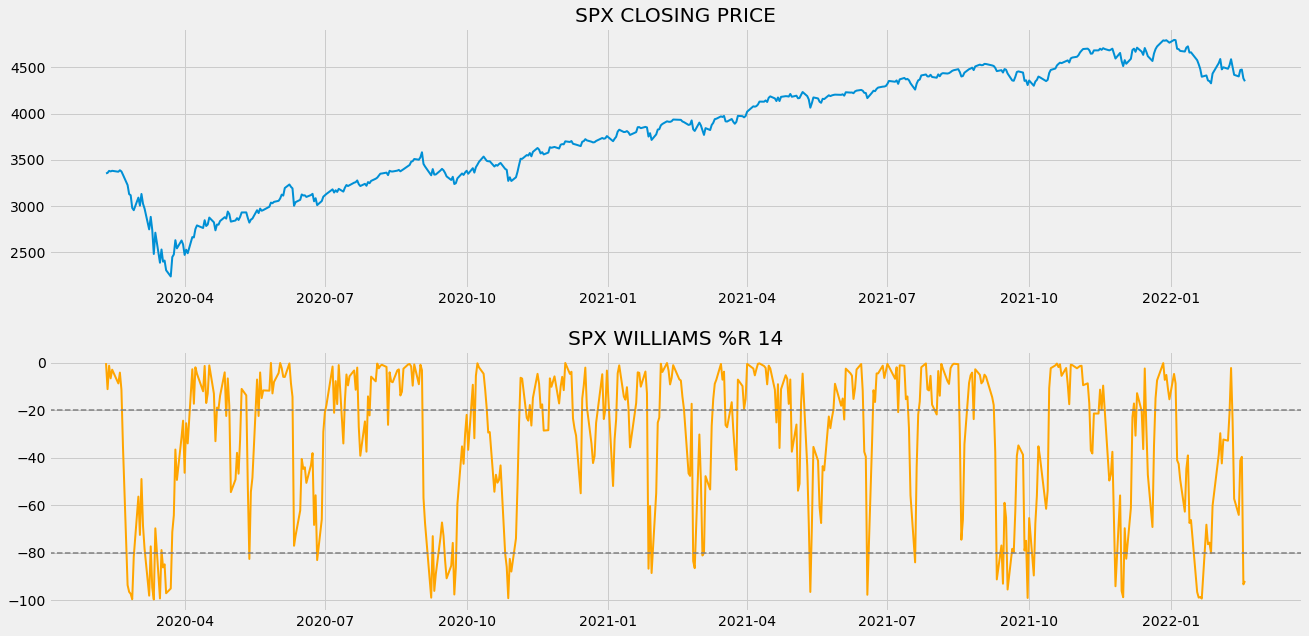

In [ ]:
## Define a function to build a dataframe to get historical data using the ticker
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(spx['close'], linewidth = 2)
ax1.set_title('SPX CLOSING PRICE')
ax2.plot(spx['wr_14'], color = 'orange', linewidth = 2)
ax2.axhline(-20, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.axhline(-80, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.set_title('SPX WILLIAMS %R 14')
plt.show()

In [ ]:
def implement_wr_strategy(prices, wr):    
    buy_price = []
    sell_price = []
    wr_signal = []
    signal = 0

    for i in range(len(wr)):
        if wr[i-1] > -80 and wr[i] < -80:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                wr_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                wr_signal.append(0)
        elif wr[i-1] < -20 and wr[i] > -20:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                wr_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                wr_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            wr_signal.append(0)
            
    return buy_price, sell_price, wr_signal
            
buy_price, sell_price, wr_signal = implement_wr_strategy(spx['close'], spx
                                                         ['wr_14'])

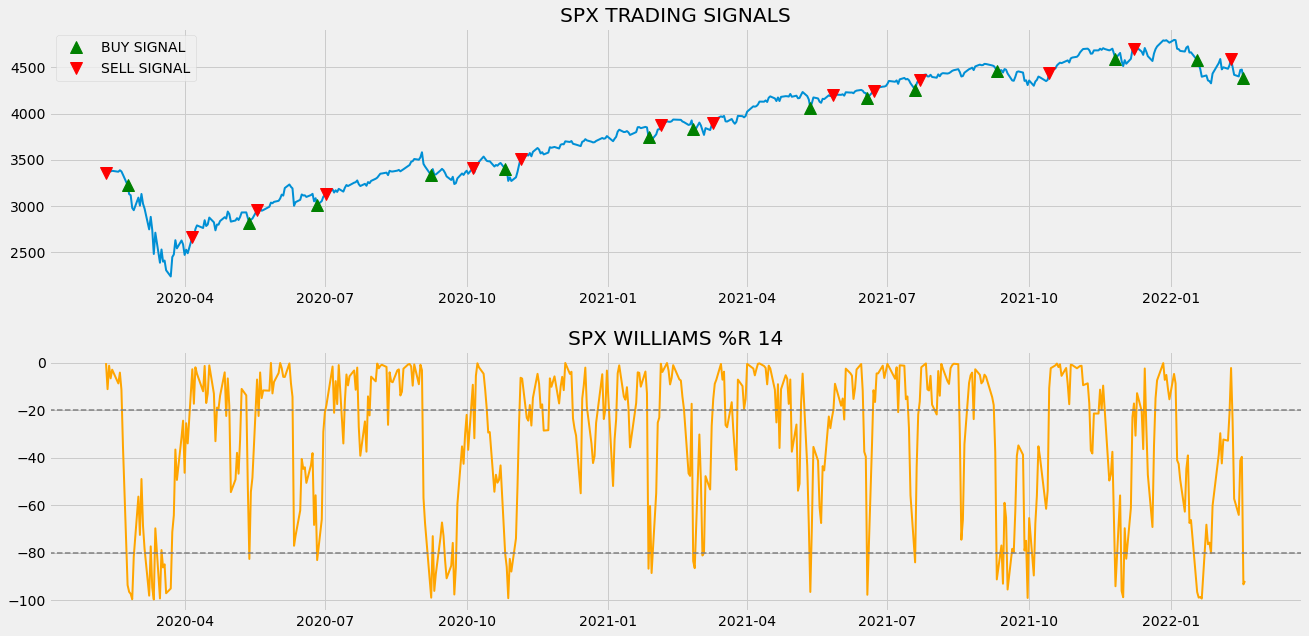

                 close      wr_14  wr_signal  wr_position
datetime                                                 
2020-02-10  3352.09009  -0.123506         -1            0
2020-02-11  3357.75000 -11.108969          0            0
2020-02-12  3379.44995  -1.211115          0            0
2020-02-13  3373.93994  -6.543125          0            0
2020-02-14  3380.15991  -2.893126          0            0
...                ...        ...        ...          ...
2022-02-14  4401.10010 -64.127421          0            0
2022-02-15  4470.70020 -41.145722          0            0
2022-02-16  4475.27979 -39.633558          0            0
2022-02-17  4380.04980 -93.400466          1            1
2022-02-18  4348.66992 -91.999059          0            1

[513 rows x 4 columns]


In [ ]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(spx['close'], linewidth = 2)
ax1.plot(spx.index, buy_price, marker = '^', markersize = 12, linewidth = 0, color = 'green', label = 'BUY SIGNAL')
ax1.plot(spx.index, sell_price, marker = 'v', markersize = 12, linewidth = 0, color = 'r', label = 'SELL SIGNAL')
ax1.legend()
ax1.set_title('SPX TRADING SIGNALS')
ax2.plot(spx['wr_14'], color = 'orange', linewidth = 2)
ax2.axhline(-20, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.axhline(-80, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.set_title('SPX WILLIAMS %R 14')
plt.show()

position = []
for i in range(len(wr_signal)):
    if wr_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(spx['close'])):
    if wr_signal[i] == 1:
        position[i] = 1
    elif wr_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = spx['close']
wr = spx['wr_14']
wr_signal = pd.DataFrame(wr_signal).rename(columns = {0:'wr_signal'}).set_index(spx.index)
position = pd.DataFrame(position).rename(columns = {0:'wr_position'}).set_index(spx.index)

frames = [close_price, wr, wr_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

print(strategy)

In [ ]:
spx_ret = pd.DataFrame(np.diff(spx['close'])).rename(columns = {0:'returns'})
wr_strategy_ret = []

for i in range(len(spx_ret)):
    returns = spx_ret['returns'][i]*strategy['wr_position'][i]
    wr_strategy_ret.append(returns)
    
wr_strategy_ret_df = pd.DataFrame(wr_strategy_ret).rename(columns = {0:'wr_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/nflx['close'][-1])
wr_investment_ret = []

for i in range(len(wr_strategy_ret_df['wr_returns'])):
    returns = number_of_stocks*wr_strategy_ret_df['wr_returns'][i]
    wr_investment_ret.append(returns)

wr_investment_ret_df = pd.DataFrame(wr_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(wr_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the W%R strategy by investing $100k in SPX : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the W%R strategy : {}%'.format(profit_percentage), attrs = ['bold']))


Profit gained from the W%R strategy by investing $100k in SPX : 140770.08
Profit percentage of the W%R strategy : 140%


In [ ]:
def get_benchmark(start_date, investment_value):
    spx = get_historical_data('SPX', start_date)['close']
    benchmark = pd.DataFrame(np.diff(spx)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spx[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('W%R Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))


Benchmark profit by investing $100k : 23998.04
Benchmark Profit percentage : 23%
W%R Strategy profit is 117% higher than the Benchmark Profit
